## Packages

In [ ]:
# Install necessary packages
!pip install memory_profiler
!pip install keras-multi-head
!pip install ipython-autotime
!pip install keras_nlp
!pip install keras-utilities

# Load Time and memory measurements
%load_ext autotime
%load_ext memory_profiler


# Import necessary libraries and modules
import numpy as np, json
import pandas as pd
import matplotlib.pyplot as plt
import pickle, sys, argparse, time, h5py
from keras.models import Model
from keras import backend as K
from keras import initializers

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras.layers import *
from keras.utils.layer_utils import get_source_inputs
from kutilities.layers import MeanOverTime
from keras_multi_head import MultiHeadAttention
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
import tensorflow as tf  
import keras_nlp
import keras

global seed
seed = 1337
np.random.seed(seed)


In [ ]:
# If run on Google colab and the datasets are in your Google drive, connect your Google drive with this notebook

from google.colab import drive
drive.mount('/content/drive')

# Unpack the required datasets, change the folder if necessary.
!unzip drive/MyDrive/ZIPYOUTUBE.zip -d /content/
!unzip drive/MyDrive/ZIPMMMO.zip -d /content/
!unzip drive/MyDrive/ZIPMOUD.zip -d /content/
!unzip drive/MyDrive/ZIPMOSI.zip -d /content/

In [ ]:
def calculate_accuracy(prediction, test_label, print_detailed_results=False):
    """
    This function calculates the Accuracy and F1-score of the prediction using this as input:
    - prediction - which containts the predicted probabilities 
    - test_label - which containts the true labels
    print_detailed_results - a boolean, which indicates if the confusion matric and Classification report should be reported
    """

    true_label=[]
    predicted_label=[]

    for i in range(prediction.shape[0]):
        true_label.append(np.argmax(test_label[i] ))
        predicted_label.append(np.argmax(prediction[i] ))
    f_score = round(f1_score(np.round(prediction),np.round(test_label),average='weighted'),5)

    if print_detailed_results:
        print ("Confusion Matrix :")
        print (confusion_matrix(true_label, predicted_label))
        print ("Classification Report :")
        print (classification_report(true_label, predicted_label))

    return accuracy_score(true_label, predicted_label), f_score

def CAM(x, y):
    """
    This is the  Context-aware Attention Module.
    This function takes in two inputs, 'x' and 'y', two modalities. 
    A dot product of the inputs along the last two axes is applied, resulting into m_dash. 
    A softmax activation function is applied to m_dash, resulting in m. Then, a dot product of m and y is taken along the last two axes.
    The resulting h_dash is then multiplied element-wise with x.
    """
    m_dash = dot([x, y], axes=[2,2])
    m = Activation('softmax')(m_dash)
    h_dash = dot([m, y], axes=[2,1])
    return multiply([h_dash, x])

In [ ]:
def featuresExtraction(dataset, classNo):
    """
        This function extracts the features using as input the dataset name and the number of classes. 
        There are 4 Datasets with the corresponding classes in brackets: MOSI(2 or 7), MMMO (2), Youtube (3) and MOUD (2). 
        Audio, video and text features are extracted for training, validation and test set. 
    """
    global train_text, train_audio, train_video, train_label
    global valid_text, valid_audio, valid_video, valid_label
    global test_text, test_audio, test_video, test_label

    if dataset == 'MOSI': 
        hf = h5py.File('/content/MOSI/X_train.h5','r')
        X_train = hf['data'][:]
        split_into_features_train = np.split(X_train, [300, 305, 325], axis=2)
        train_text = split_into_features_train[0]
        train_audio = split_into_features_train[1]
        train_video = split_into_features_train[2]

        hf = h5py.File('/content/MOSI/X_test.h5','r')
        X_test = hf['data'][:]
        split_into_features_test = np.split(X_test, [300, 305, 325], axis=2)
        test_text = split_into_features_test[0]
        test_audio = split_into_features_test[1]
        test_video = split_into_features_test[2]

        hf = h5py.File('/content/MOSI/X_valid.h5','r')
        X_valid = hf['data'][:]
        split_into_features_valid = np.split(X_valid, [300, 305, 325], axis=2)
        valid_text = split_into_features_valid[0]
        valid_audio = split_into_features_valid[1]
        valid_video = split_into_features_valid[2]

        hf = h5py.File('/content/MOSI/y_train.h5','r')
        y_train = hf['data'][:]

        hf = h5py.File('/content/MOSI/y_test.h5','r')
        y_test = hf['data'][:]

        hf = h5py.File('/content/MOSI/y_valid.h5','r')
        y_valid = hf['data'][:]

        if classNo == 2:

            test_label = [[1, 0] if val < 0 else [0, 1] for val in y_test]
            test_label = np.array(test_label)

            train_label = [[1, 0] if val < 0 else [0, 1] for val in y_train]
            train_label = np.array(train_label)

            valid_label = [[1, 0] if val < 0 else [0, 1] for val in y_valid]
            valid_label = np.array(valid_label)

        if classNo == 7: 

            y_train = np.round(y_train)
            train_label = to_categorical(y_train - y_train.min())

            y_test = np.round(y_test)
            test_label = to_categorical(y_test - y_test.min())

            y_valid = np.round(y_valid)
            valid_label = to_categorical(y_valid - y_valid.min())

    else:

          with open('/content/' + dataset + '/covarep_train.p', 'rb') as f:
              train_audio = pickle.load(f, encoding='latin1')
          train_audio = train_audio/np.max(train_audio)

          with open('/content/' + dataset + '/covarep_valid.p', 'rb') as f:
              valid_audio = pickle.load(f, encoding='latin1')
          valid_audio = valid_audio/np.max(valid_audio)


          with open('/content/' + dataset + '/covarep_test.p', 'rb') as f:
              test_audio = pickle.load(f, encoding='latin1')
          test_audio  = test_audio/np.max(test_audio)

          with open ('/content/' + dataset + '/facet_train.p', 'rb') as f:
              train_video = pickle.load(f, encoding='latin1')
          train_video = train_video/np.max(train_video)

          with open ('/content/' + dataset + '/facet_valid.p', 'rb') as f:
              valid_video = pickle.load(f, encoding='latin1')
          valid_video = valid_video/np.max(valid_video)

          with open('/content/' + dataset + '/facet_test.p', 'rb') as f:
              test_video  = pickle.load(f, encoding='latin1')
          test_video  = test_video/np.max(test_video)

          with open('/content/' + dataset + '/text_train.p', 'rb') as f:
              train_text  = pickle.load(f, encoding='latin1')
          train_text  = train_text/np.max(train_text)

          with open('/content/' + dataset + '/text_valid.p', 'rb') as f:
              valid_text  = pickle.load(f, encoding='latin1')
          valid_text  = valid_text/np.max(valid_text)

          with open('/content/' + dataset + '/text_test.p', 'rb') as f:
              test_text   = pickle.load(f, encoding='latin1')
          test_text   = test_text/np.max(test_text)

          if dataset == 'MMMO':
                with open('/content/' + dataset + '/y_train.p', 'rb') as f:
                    train_label = pickle.load(f, encoding='latin1')
                train_label = [[1, 0] if val <= 3.5 else [0, 1] for val in train_label]
                train_label = np.array(train_label)

                with open('/content/' + dataset + '/y_valid.p', 'rb') as f:
                    valid_label = pickle.load(f, encoding='latin1')
                valid_label = [[1, 0] if val <= 3.5 else [0, 1] for val in valid_label]
                valid_label = np.array(valid_label)

                with open('/content/' + dataset + '/y_test.p', 'rb') as f:
                    test_label  = pickle.load(f, encoding='latin1')
                test_label = [[1, 0] if val <= 3.5 else [0, 1] for val in test_label]
                test_label = np.array(test_label)
          else:
          
              with open('/content/' + dataset + '/y_train.p', 'rb') as f:
                  train_label = pickle.load(f, encoding='latin1')
              with open('/content/' + dataset + '/y_valid.p', 'rb') as f:
                  valid_label = pickle.load(f, encoding='latin1')
              with open('/content/' + dataset + '/y_test.p', 'rb') as f:
                  test_label  = pickle.load(f, encoding='latin1')

# Proposed Multi-head self-attention with context-aware attention model (MHCA)

In [ ]:
global seed
seed = 1337
np.random.seed(seed)
def MHCA_model(dataset,classNo, drop, neurons):
    """
        This function implements the Proposed Multi-head self-attention with context-aware attention model (MHCA). 
        The MHCA model consists of three main components: a Multi-Head Attention (MHA) module, a fully connected layer 
        with dropout (Dense Layer + Dropout), and a Context-aware Attention (CAM) module.
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys           = 'text_audio_video' 
    runs                = 1
    acc       = 0

    for run in range(runs):

        in_test_label   = []		
		    # Shape of Modalitys
        text_shape      = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape     = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape     = Input(shape=(train_video.shape[1], train_video.shape[2]))


        # ============ Multi-Head Attention (MHA) Module  ======================
        text_MHA        = MultiHeadAttention(head_num =5)(text_shape)           # All (5)
        audio_MHA       = MultiHeadAttention(head_num =2)(audio_shape)          # MOSI (5), YOUTUBE, MOUD, MMMO (2)
        video_MHA       = MultiHeadAttention(head_num =7)(video_shape)          # MOSI (5), YOUTUBE, MOUD, MMMO (7)

        # ============ Dense Module ============================================
        text_MHA_fc     = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh' ))(text_MHA))
        audio_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_MHA))
        video_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_MHA))

        # ============  Context-aware Attention (CAM) Module ===================
        cam_TA          = CAM(text_MHA_fc, audio_MHA_fc)
        cam_TV          = CAM(text_MHA_fc, video_MHA_fc)
        cam_AV          = CAM(audio_MHA_fc, video_MHA_fc)

		    # ============ Concatenation ===========================================	

        merged          = concatenate([cam_TA,cam_TV,cam_AV])
        merged          = Dense(neurons, activation='relu')(merged)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model           = Model(inputs=[text_shape,audio_shape,video_shape],
                                outputs=[audio_shape,video_shape,text_shape,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)
        #model.summary()

        path            = '/content/drive/MyDrive/weights/' + time +'_' +dataset + '_' + str(modalitys)+'_' + str(drop) + '_' + str(neurons)+ '_' +str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train_text,train_audio,train_video], 
                                  [train_audio,train_video,train_text,train_label],
                                   epochs=50,
                                   batch_size=2,
                                   shuffle=True,
                                   callbacks=[check1, check2],
                                   validation_data=([valid_text,valid_audio,valid_video], 
                                                   [valid_audio,valid_video,valid_text,valid_label]),
                                                    verbose=0)
        model.load_weights(path)
        result          = model.predict([test_text,test_audio,test_video])
        #model.summary()

        result[-1]      = np.nan_to_num(result[-1])
        test_label_     = [array.tolist() for array in test_label]
        acc, f1_score   = calculate_accuracy(result[-1], test_label_, True)

        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)

        open('/content/drive/MyDrive/results/'+  dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) + '.txt', 'a').write(str(acc)+'_' + str(time)+'_' + str(run)  + '\n')  
        with open('/content/drive/MyDrive/history/'+  time + dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) +'_'+str(run)+'_'+'history.pkl', 'wb') as file:
            pickle.dump(history.history, file)
        print(path)

       # ============ Plot Accuracy & Loss History =============================
  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()   
        %load_ext autotime

       # ============ Set time (For distinction later), dataset, number of classes, the droprate and number of neurons in the Dense layer with Dropout =============================

time = '13:26'
dataset                 = 'YOUTUBE'                                             # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'MHA_Dense_CAM'       
classNo                 = 3                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.3                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 50                                                    # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)
%memit (MHCA_model(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons))

## Experiments

### Unimodal vs. Bimodal vs. Trimodal

#### Uni-modality

In [ ]:
def MHCA_Unimodal(dataset,classNo, drop, neurons, modality):
    """
        This function implements the MHCA model with using only one modality (uni-modal) using
        the inputs: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), the number of neurons in the dense layer (neurons), and the selected modality for training uni-modal.
    """
    if modality == 'text':
        train = train_text
        valid = valid_text
        test = test_text
    if modality == 'audio':
        train = train_audio
        valid = valid_audio
        test = test_audio
    if modality == 'video':
        train = train_video
        valid = valid_video
        test = test_video

    if dataset == 'MOSI':
        heads = 5
    elif modality == 'text':
        heads = 5
    elif modality == 'audio':
        heads = 2
    elif modality == 'video':
        heads = 7        

    runs                = 1
    acc                 = 0

    for run in range(runs):
        in_test_label   = []		
		    # Shape of Modalitys
        shape           = Input(shape=(train.shape[1], train.shape[2]))

        # =================== Multi-Head Attention Module ======================
        MHA        = MultiHeadAttention(head_num = heads)(shape)
        # ============ Dense Module ============================================
        MHA_fc     = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(MHA))

        # ===============  Context-aware Attention (CAM) Module ================
        cam_uniModal          = CAM(MHA, MHA)
	    	# ==================== Concatenation ===================================	
        merged          = Dense(neurons, activation='relu')(cam_uniModal)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ======================== Model =======================================
        model           = Model(inputs=shape,
                                outputs=final_output)
        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + time +'_' +dataset + '_' + str(modality)+'_' + str(drop) + '_' + str(neurons)+ '_' +str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit(train, train_label,
                                    epochs=50,
                                    batch_size=2,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=(valid, valid_label),
                                    verbose=0)
        #model.load_weights(path)
        result          = model.predict(test)
        result = np.nan_to_num(result)
        test_label_     = [array.tolist() for array in test_label]


        acc, f1_score   = calculate_accuracy(result, test_label, True)
        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)
        open('/content/drive/MyDrive/results/'+  dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) + '.txt', 'a').write(str(acc)+'_' + str(time)+'_' + str(run) + '_' + '\n')  
        with open('/content/drive/MyDrive/history/'+  time +dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) +'_'+str(run)+'_'+'history.pkl', 'wb') as file:
            pickle.dump(history.history, file)
        print(path)

  
       # ============ Plot Accuracy & Loss History =============================
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['acc'])
        ax1.plot(history.history['val_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')
        plt.show()   
        %load_ext autotime

# Set time (For distinction later), dataset, number of classes, the droprate and number of neurons in the Dense layer with Dropout 

time                    = '15:23'
dataset                 = 'MOSI'  
classNo                 = 2
modality                = 'audio'
modelType               = 'MHCA_Unimodal' + '_' + modality
drop                    = 0.3
neurons                 = 50

featuresExtraction(dataset, classNo)  
%load_ext memory_profiler
%memit (MHCA_Unimodal(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons, modality=modality))

#### Bi-modality

In [ ]:
def get_data_and_heads(modality, dataset):
    """
        This function is to get the data and number of heads corresponding to the given modality using the inputs: the selected dataset (dataset),
        and the selected modality
    """
    if modality == 'text':
        train = train_text
        valid = valid_text
        test = test_text
    elif modality == 'audio':
        train = train_audio
        valid = valid_audio
        test = test_audio
    elif modality == 'video':
        train = train_video
        valid = valid_video
        test = test_video

    if dataset == 'MOSI':
        heads = 5
    elif modality == 'text':
        heads = 5
    elif modality == 'audio':
        heads = 2
    elif modality == 'video':
        heads = 7

    return train, valid, test, heads



def MHCA_Bimodal(dataset,classNo, drop, neurons, modality1, modality2):
    """
        This function implements the MHCA model with using two modalities (bi-modal) using
        the inputs: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), the number of neurons in the dense layer (neurons), and the selected modalitys for training bi-modal.
    """
    train1, valid1, test1, heads1 = get_data_and_heads(modality1, dataset) 
    train2, valid2, test2, heads2 = get_data_and_heads(modality2, dataset)
    runs                = 1
    acc                 = 0

    for run in range(runs):
        in_test_label   = []		
		    # Shape of Modalitys
        shape1          = Input(shape=(train1.shape[1], train1.shape[2]))
        shape2          = Input(shape=(train2.shape[1], train2.shape[2]))

        # ============ Multi-Head Attention Module ======================
        MHA1            = MultiHeadAttention(head_num =heads1)(shape1)
        MHA2            = MultiHeadAttention(head_num =heads2)(shape2)
        # ============ Dense Module ============================================

        MHA_fc_1        = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(MHA1))
        MHA_fc_2        = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(MHA2))

		    # ============  Context-aware Attention Module ======================
        cam             = CAM(MHA_fc_1, MHA_fc_2)

		    # ============  Concatenate ======================	
        merged          = Dense(neurons, activation='relu')(cam)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ======================================= Model ===============================================

        model           = Model(inputs=[shape1,shape2],
                                outputs=[shape2,shape1,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + time +'_' +dataset + '_' + str(modality1)+'_'+str(modality2)+'_' + str(drop) + '_' + str(neurons)+ '_' +str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train1,train2], 
                                    [train2,train1,train_label],
                                    epochs=50,
                                    batch_size=2,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=([valid1,valid2], 
                                    [valid2,valid1,valid_label]),
                                    verbose=0)
        model.load_weights(path)
        result          = model.predict([test1,test2])
        result[-1]      = np.nan_to_num( result[-1])

        acc, f1_score   = calculate_accuracy(result[-1], test_label, True)
        print('best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)
        open('/content/drive/MyDrive/results/'+  dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) + '.txt', 'a').write(str(acc)+'_' + str(time)+'_' + str(run)  +'_F1_' + str(f1_score) + '\n')  
        with open('/content/drive/MyDrive/history/'+  time +dataset + str(classNo)+ '_' + modelType + '_' + str(drop)+'_'+str(neurons) +'_'+str(run)+'_'+'history.pkl', 'wb') as file:
            pickle.dump(history.history, file)
        print(path)

  
       # ============ Plot Accuracy & Loss History =============================
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()  
        %load_ext autotime
		
time                    = '00:32'
dataset                 = 'MOUD'                                                # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modality1               = 'text'
modality2               = 'audio'
modelType               = 'MHCA_Bimodal' + '_' + modality1 + '_' + modality2
classNo                 = 2                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.9                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 100                                                   # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)   # hier ersetzen
%load_ext memory_profiler
%memit (MHCA_Bimodal(dataset=dataset, classNo=classNo, neurons=neurons, drop=drop, modality1=modality1, modality2=modality2))

### Cross-attention vs. self-attention

In [ ]:
from keras_multi_head import MultiHeadAttention
import time
import pickle 
import matplotlib.pyplot as plt


def MHCA_crossModel(dataset,classNo, drop, neurons):
    """
        This function implements the MHCA model but instead of self-attention it uses cross-attention in the Multi-Head Attention (MHA) module
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys  = 'text_audio_video' 
    runs = 1
    acc = 0

    for run in range(runs):
		    # Shape of Modalitys
        text_shape         = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape        = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape        = Input(shape=(train_video.shape[1], train_video.shape[2]))


        # ============ Multi-Head Attention (MHA) Module  ======================
        text_audio_MHA     = MultiHeadAttention(head_num =5)([text_shape, audio_shape, audio_shape])
        text_video_MHA     = MultiHeadAttention(head_num =5)([text_shape, video_shape, video_shape])
        audio_video_MHA    = MultiHeadAttention(head_num =5)([audio_shape, video_shape, video_shape])

        audio_text_MHA     = MultiHeadAttention(head_num =5)([audio_shape, text_shape, text_shape])
        video_text_MHA     = MultiHeadAttention(head_num =5)([video_shape, text_shape, text_shape])
        video_audio_MHA    = MultiHeadAttention(head_num =5)([video_shape, audio_shape, audio_shape])
        # ============ Dense Module ============================================

        text_audio_MHA_fc  = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(text_audio_MHA))
        text_video_MHA_fc  = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(text_video_MHA))
        audio_video_MHA_fc = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_video_MHA))


        audio_text_MHA_fc  = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_text_MHA))
        video_text_MHA_fc  = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_text_MHA))
        video_audio_MHA_fc = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_audio_MHA))

        # ============  Context-aware Attention (CAM) Module ===================
        cam_1              = CAM(text_audio_MHA_fc, text_video_MHA_fc)
        cam_2              = CAM(text_audio_MHA_fc, audio_video_MHA_fc)
        cam_3              = CAM(text_audio_MHA_fc, audio_text_MHA_fc)
        cam_4              = CAM(text_audio_MHA_fc, video_text_MHA_fc)
        cam_5              = CAM(text_audio_MHA_fc, video_audio_MHA_fc)

        cam_6              = CAM(text_video_MHA_fc,audio_video_MHA_fc )
        cam_7              = CAM(text_video_MHA_fc, audio_text_MHA_fc)
        cam_8              = CAM(text_video_MHA_fc, video_text_MHA_fc)
        cam_9              = CAM(text_video_MHA_fc, video_audio_MHA_fc)

        cam_10              = CAM(audio_video_MHA_fc,audio_text_MHA_fc )
        cam_11              = CAM(audio_video_MHA_fc, video_text_MHA_fc)
        cam_12              = CAM(audio_video_MHA_fc, video_audio_MHA_fc)

        cam_13              = CAM(audio_text_MHA_fc, video_text_MHA_fc)
        cam_14              = CAM(audio_text_MHA_fc, video_audio_MHA_fc)

        cam_15              = CAM(video_text_MHA_fc, video_audio_MHA_fc)
    		# ============ Concatenation ===========================================	
        merged              = concatenate([cam_1,cam_2,cam_3,cam_4,cam_5,cam_6,cam_7,cam_8,cam_9,cam_10,cam_11,cam_12, cam_13,cam_14,cam_15])
        merged              = Dense(neurons, activation='relu')(merged)
        merged              = MeanOverTime()(merged)
        final_output        = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model               = Model(inputs=[text_shape,audio_shape,video_shape],
                              outputs=[audio_shape,video_shape,text_shape,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)


        path                = '/content/drive/MyDrive/weights/' + dataset + str(modalitys)+'_'+str(run)+'.hdf5'
        check1              = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2              = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history             = model.fit([train_text,train_audio,train_video], 
                                        [train_audio,train_video,train_text,train_label],
                                        epochs=50,
                                        batch_size=16,
                                        shuffle=True,
                                        callbacks=[check1, check2],
                                        validation_data=([valid_text,valid_audio,valid_video], 
                                        [valid_audio,valid_video,valid_text,valid_label]),
                                        verbose=1)

        model.load_weights(path)
        result              = model.predict([test_text,test_audio,test_video])
        result[-1]      = np.nan_to_num(result[-1])

        #model.summary()
        acc, f1_score       = calculate_accuracy(result[-1], test_label, True)
        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)
        open('/content/drive/MyDrive/results/'+ dataset +'_'+ str(classNo)+ '_' + modelType + '_'+'.txt', 'a').write(str(acc) + '\n'*2)  

       # ============ Plot Accuracy & Loss History =============================
        fig, (ax1, ax2)     = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['acc'])
        ax1.plot(history.history['val_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')
        plt.show()   
        %load_ext autotime

dataset                     = 'MOSI'                                            # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType                   = 'Cross_MHA_Dense_CAM'       
classNo                     = 2                                                 # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                        = 0.8                                               # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                     = 200                                               # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)   # hier ersetzen
MHCA_crossModel(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons)



### MHA module vs. Transformer

 The MHA module was replaced with a Transformer encoder

In [ ]:

def MHCA_transformer(dataset, classNo, drop, neurons):
    """
        This function implements the MHCA model but instead of the Multi-Head Attention (MHA) module it uses Transformer encoder
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys  = 'text_audio_video' 
    runs = 1
    acc = 0

    for run in range(runs):
		 # Shape of Modalitys
        text_shape                  = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape                  = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape                  = Input(shape=(train_video.shape[1], train_video.shape[2]))

        # ============ TransformerEncoder ======================
        text_MHA_transformerEncoder  = keras_nlp.layers.TransformerEncoder(intermediate_dim=neurons, num_heads=5, name='TransformerText')
        output_text_transformer      = text_MHA_transformerEncoder(text_shape)
        
        audio_MHA_transformerEncoder = keras_nlp.layers.TransformerEncoder(intermediate_dim=neurons, num_heads=5, name='TransformerAudio')
        output_audio_transformer     = audio_MHA_transformerEncoder(audio_shape)

        video_MHA_transformerEncoder = keras_nlp.layers.TransformerEncoder(intermediate_dim=neurons, num_heads=5, name='TransformerVisual')
        output_video_transformer     = video_MHA_transformerEncoder(video_shape)

        # ============ Dense Module ============================================
        text_MHA_fc     = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(output_text_transformer))
        audio_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(output_audio_transformer))
        video_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(output_video_transformer))


        # ============  Context-aware Attention (CAM) Module ===================

        cam_TA          = CAM(text_MHA_fc, audio_MHA_fc)
        cam_TV          = CAM(text_MHA_fc, video_MHA_fc)
        cam_AV          = CAM(audio_MHA_fc, video_MHA_fc)

        
        cam_AT          = CAM(audio_MHA_fc, text_MHA_fc )
        cam_VT          = CAM(video_MHA_fc, text_MHA_fc )
        cam_VA          = CAM(video_MHA_fc, audio_MHA_fc)


        # cam_TA = CAM(output_text_transformer, output_audio_transformer)
        # cam_TV = CAM(output_text_transformer, output_video_transformer)
        # cam_AV = CAM(output_audio_transformer, output_video_transformer)

        
        # cam_AT = CAM(output_audio_transformer, output_text_transformer )
        # cam_VT = CAM(output_video_transformer, output_text_transformer )
        # cam_VA = CAM(output_video_transformer, output_audio_transformer)


		# ============ Concatenation ===========================================	
        merged          = concatenate([cam_TA,cam_TV,cam_AV, cam_AT, cam_VT, cam_VA])
        merged          = Dense(neurons, activation='relu')(merged)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model           = Model(inputs=[text_shape,audio_shape,video_shape],
                                outputs=[audio_shape,video_shape,text_shape,final_output])
 
        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_transformer_dense_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + dataset + str(modalitys)+'_'+str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train_text,train_audio,train_video], 
                                    [train_audio,train_video,train_text,train_label],
                                    epochs=50,
                                    batch_size=16,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=([valid_text,valid_audio,valid_video], 
                                    [valid_audio,valid_video,valid_text,valid_label]),
                                    verbose=1)

        model.load_weights(path)
        result          = model.predict([test_text,test_audio,test_video])
        result[-1]      = np.nan_to_num(result[-1])

        #model.summary()
        acc, f1_score   = calculate_accuracy(result[-1], test_label, True)

        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)

        open('/content/drive/MyDrive/results/'+ dataset + '_' + modelType + '_'+ modalitys+'.txt', 'a').write(modalitys + ', accuracy: ' + str(acc) + '\n'*2)  

       # ============ Plot Accuracy & Loss History =============================
  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()   
        %load_ext autotime

  
dataset                 = 'MOSI'                                                # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'MHA_Transformer_Dense_CAM'        
classNo                 = 7                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.8                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 200                                                   # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)
MHCA_transformer(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons)


### Ablation Study: Without MHA Module, Solo CAM

In [ ]:


def MHCA_withoutMHA(dataset,classNo, drop, neurons):
    """
        This function implements the MHCA model but without the MHA module. 
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys  = 'text_audio_video' 
    runs = 1
    acc = 0

    for run in range(runs):
	    # Shape of Modalitys
        text_shape      = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape     = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape     = Input(shape=(train_video.shape[1], train_video.shape[2]))
		
        # ============ Dense Module ============================================
        text_MHA_fc     = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(text_shape))
        audio_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_shape))
        video_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_shape))


        # ============  Context-aware Attention (CAM) Module ===================
        cam_TA          = CAM(text_MHA_fc, audio_MHA_fc)
        cam_TV          = CAM(text_MHA_fc, video_MHA_fc)
        cam_AV          = CAM(audio_MHA_fc, video_MHA_fc)


		# ============ Concatenation ===========================================	
        merged          = concatenate([cam_TA,cam_TV,cam_AV])
        merged          = Dense(neurons, activation='relu')(merged)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model           = Model(inputs=[text_shape,audio_shape,video_shape],
                                outputs=[audio_shape,video_shape,text_shape,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + dataset + str(modalitys)+'_'+str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train_text,train_audio,train_video], 
                                    [train_audio,train_video,train_text,train_label],
                                    epochs=50,
                                    batch_size=16,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=([valid_text,valid_audio,valid_video], 
                                    [valid_audio,valid_video,valid_text,valid_label]),
                                    verbose=1)

        model.load_weights(path)
        result          = model.predict([test_text,test_audio,test_video])
        #model.summary()
        acc, f1_score   = calculate_accuracy(result[-1], test_label, True)
        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)

        open('/content/drive/MyDrive/results/'+ dataset + '_' + modelType + '_'+ str(drop) + '_' + str(neurons) +'.txt', 'a').write(str(acc) + '\n'*2)  

       # ============ Plot Accuracy & Loss History =============================
  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()    
        %load_ext autotime


dataset                 = 'MOSI'                                                # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'SOLO_CAM'       
classNo                 = 7                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.8                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 200                                                   # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)   # hier ersetzen
MHCA_withoutMHA(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons)

### Ablation Study: Without CAM Module, Solo MHA

In [ ]:
def MHCA_withoutCAM(dataset,classNo, drop, neurons):
    """
        This function implements the MHCA model but without the CAM module. 
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys  = 'text_audio_video' 
    runs = 1
    acc = 0

    for run in range(runs):
		 # Shape of Modalitys
        text_shape     = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape    = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape    = Input(shape=(train_video.shape[1], train_video.shape[2]))


        # ============ Multi-Head Attention (MHA) Module  ======================
        text_MHA       = MultiHeadAttention(head_num =5)(text_shape)            # All (5)
        audio_MHA      = MultiHeadAttention(head_num =2)(audio_shape)           # MOSI (5), YOUTUBE, MOUD, MMMO (2)
        video_MHA      = MultiHeadAttention(head_num =7)(video_shape)           # MOSI (5), YOUTUBE, MOUD, MMMO (7)


	    	# ============ Concatenation ===========================================	
        merged          = concatenate([text_MHA,audio_MHA,video_MHA])
        merged          = Dense(neurons, activation='relu')(merged)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model           = Model(inputs=[text_shape,audio_shape,video_shape],
                                outputs=[audio_shape,video_shape,text_shape,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        # plot_model(model, to_file='MHA_and_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + dataset + str(modalitys)+'_'+str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train_text,train_audio,train_video], 
                                    [train_audio,train_video,train_text,train_label],
                                    epochs=50,
                                    batch_size=16,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=([valid_text,valid_audio,valid_video], 
                                    [valid_audio,valid_video,valid_text,valid_label]),
                                    verbose=1)

        model.load_weights(path)
        result          = model.predict([test_text,test_audio,test_video])
        result[-1]      = np.nan_to_num(result[-1])
        #model.summary()
        acc, f1_score   = calculate_accuracy(result[-1], test_label, True)
        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)
        open('/content/drive/MyDrive/results/'+ dataset + '_' + modelType + '_'+ modalitys+'.txt', 'a').write(str(acc) + '\n'*2)  


       # ============ Plot Accuracy & Loss History =============================
  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()   
        %load_ext autotime

dataset                 = 'YOUTUBE'                                             # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'SOLO_MHA'       
classNo                 = 3                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.3                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 50                                                    # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)
MHCA_withoutCAM(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons)


### Reversed-Order: Dense + CAM + MHA

In [ ]:
def MHCA_Order(dataset,classNo, drop, neurons):
    """
        This function implements the MHCA model but changes the order of the MHA and CAM module.  
        The inputs are: the selected dataset (dataset), the number of classes of the dataset (classNo), the dropout rate
        in the dense layer (drop), and the number of neurons in the dense layer (neurons).
    """
    modalitys  = 'text_audio_video' 
    runs = 1
    acc = 0

    for run in range(runs):
		    # Shape of Modalitys
        text_shape     = Input(shape=(train_text.shape[1], train_text.shape[2]))
        audio_shape    = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
        video_shape    = Input(shape=(train_video.shape[1], train_video.shape[2]))

        # ============ Dense Module ============================================
        text_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(text_shape))
        audio_MHA_fc   = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_shape))
        video_MHA_fc   = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_shape))
  
        # ============  Context-aware Attention (CAM) Module ===================
        cam_TA          = CAM(text_MHA_fc, audio_MHA_fc)
        cam_TV          = CAM(text_MHA_fc, video_MHA_fc)
        cam_AV          = CAM(audio_MHA_fc, video_MHA_fc)

        # ============ Multi-Head Attention (MHA) Module  ======================
        text_MHA        = MultiHeadAttention(head_num =5)(cam_TA)
        audio_MHA       = MultiHeadAttention(head_num =5)(cam_TV)
        video_MHA       = MultiHeadAttention(head_num =5)(cam_AV)


    		# ============ Concatenation ===========================================	
        merged          = concatenate([text_MHA,audio_MHA,video_MHA])
        merged          = Dense(neurons, activation='relu')(merged)
        merged          = MeanOverTime()(merged)
        final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

        # ============ Model ===================================================

        model           = Model(inputs=[text_shape,audio_shape,video_shape],
                                outputs=[audio_shape,video_shape,text_shape,final_output])

        model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
        plot_model(model, to_file='MHA_Dense_CAM.png', show_shapes=True, show_layer_names=True)


        path            = '/content/drive/MyDrive/weights/' + dataset + str(modalitys)+'_'+str(run)+'.hdf5'
        check1          = EarlyStopping(monitor='val_final_output_loss', patience=20)
        check2          = ModelCheckpoint(path, monitor='val_final_output_acc', verbose=1, save_weights_only=True,  save_best_only=True, mode='max')


        history         = model.fit([train_text,train_audio,train_video], 
                                    [train_audio,train_video,train_text,train_label],
                                    epochs=50,
                                    batch_size=16,
                                    shuffle=True,
                                    callbacks=[check1, check2],
                                    validation_data=([valid_text,valid_audio,valid_video], 
                                    [valid_audio,valid_video,valid_text,valid_label]),
                                    verbose=1)

        model.load_weights(path)
        result          = model.predict([test_text,test_audio,test_video])
        result[-1]      = np.nan_to_num(result[-1])

        #model.summary()
        acc, f1_score = calculate_accuracy(result[-1], test_label, True)

        print('Best accuracy is: ', acc)
        print('F1 Score is: ', f1_score)

        open('/content/drive/MyDrive/results/'+ dataset + '_' + modelType + '_'+ modalitys+'.txt', 'a').write(modalitys + ', accuracy: ' + str(acc) + '\n'*2)  


       # ============ Plot Accuracy & Loss History =============================
  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(history.history['final_output_acc'])
        ax1.plot(history.history['val_final_output_acc'])
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Training', 'Validation'], loc='lower right')
        ax2.plot(history.history['final_output_loss'])
        ax2.plot(history.history['val_final_output_loss'])
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Training', 'Validation'], loc='lower right')

        plt.show()     
        %load_ext autotime

dataset                 = 'MOSI'                                                # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'Order_CAM_Dense_MHA'       
classNo                 = 7                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.8                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 200                                                   # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
featuresExtraction(dataset, classNo)   # hier ersetzen
MHCA_Order(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons)

# Load Weights or Results


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


22/22 [==============================] - 1s 5ms/step
Confusion Matrix :
[[329  50]
 [ 89 218]]
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       379
           1       0.81      0.71      0.76       307

    accuracy                           0.80       686
   macro avg       0.80      0.79      0.79       686
weighted avg       0.80      0.80      0.80       686

Best accuracy is:  0.7973760932944607
F1 Score is:  0.79929


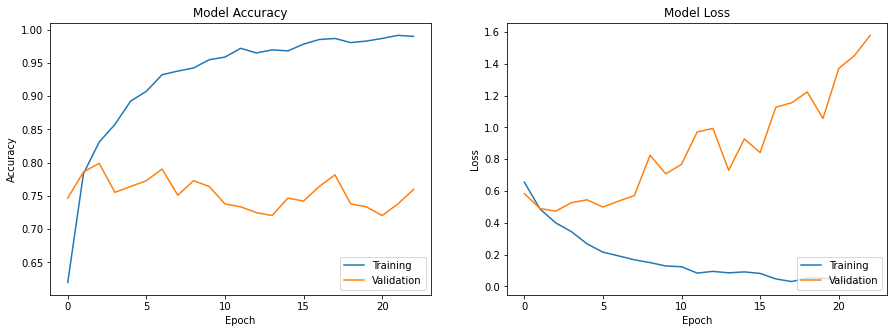

peak memory: 2396.18 MiB, increment: 84.57 MiB
time: 2.51 s (started: 2023-02-14 14:41:40 +00:00)


In [ ]:
def Load_weights_history(dataset,classNo, drop, neurons, weights_path, history_path):

  acc = 0

	# Shape of Modalitys
  text_shape      = Input(shape=(train_text.shape[1], train_text.shape[2]))
  audio_shape     = Input(shape=(train_audio.shape[1], train_audio.shape[2]))
  video_shape     = Input(shape=(train_video.shape[1], train_video.shape[2]))


	# ============ Multi-Head Attention (MHA) Module  ======================
  text_MHA        = MultiHeadAttention(head_num =5)(text_shape)           # All (5)
  audio_MHA       = MultiHeadAttention(head_num =5)(audio_shape)          # MOSI (5), YOUTUBE, MOUD, MMMO (2)
  video_MHA       = MultiHeadAttention(head_num =5)(video_shape)          # MOSI (5), YOUTUBE, MOUD, MMMO (7)

	# ============ Dense Module ============================================
  text_MHA_fc     = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh' ))(text_MHA))
  audio_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(audio_MHA))
  video_MHA_fc    = Dropout(drop)(TimeDistributed(Dense(neurons, activation='tanh'))(video_MHA))

	# ============  Context-aware Attention (CAM) Module ===================
  cam_TA          = CAM(text_MHA_fc, audio_MHA_fc)
  cam_TV          = CAM(text_MHA_fc, video_MHA_fc)
  cam_AV          = CAM(audio_MHA_fc, video_MHA_fc)

	# ============ Concatenation ===========================================	

  merged          = concatenate([cam_TA,cam_TV,cam_AV])
  merged          = Dense(neurons, activation='relu')(merged)
  merged          = MeanOverTime()(merged)
  final_output    = Dense(classNo, activation='softmax', name='final_output')(merged)   # hier anpassen wieviele outputs man hat!!

	# ============ Model ===================================================

  model 			= Model(inputs=[text_shape,audio_shape,video_shape],
				  outputs=[audio_shape,video_shape,text_shape,final_output])
  model.compile(loss=['mse','mse','mse','categorical_crossentropy'], sample_weight_mode='None', optimizer='adam', metrics=['acc'])
  
  model.load_weights(weights_path)
  result 	        = model.predict([test_text,test_audio,test_video])
  result[-1]      = np.nan_to_num( result[-1])
  test_label_     = [array.tolist() for array in test_label]
  acc, f1_score  = calculate_accuracy(result[-1], test_label_, True)

  print('Best accuracy is: ', acc)
  print('F1 Score is: ', f1_score)

  with open(history_path, 'rb') as file:
    history = pickle.load(file)

  fig, (ax1, ax2)     = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(history['final_output_acc'])
  ax1.plot(history['val_final_output_acc'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Training', 'Validation'], loc='lower right')
  ax2.plot(history['final_output_loss'])
  ax2.plot(history['val_final_output_loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Training', 'Validation'], loc='lower right')

  plt.show()    

dataset                 = 'MOSI'                                             # Datasets: MOSI, YOUTUBE, MOUD, MMMO
modelType               = 'MHA_Dense_CAM'       
classNo                 = 2                                                     # MOSI (2,7), YOUTUBE (3), MOUD (2), MMMO (2)
drop                    = 0.8                                                   # MOSI (0.8), YOUTUBE (0.3), MOUD & MMMO (0.9)
neurons                 = 200                                                    # MOSI (200), YOUTUBE (50), MOUD & MMMO (100)
weights_path            = '/content/14_59_MOSI_text_audio_video_0.8_200_2.hdf5'
history_path            = '/content/14_59MOSI2_MHA_Dense_CAM_0.8_200_2_history.pkl'
featuresExtraction(dataset, classNo)
%memit (Load_weights_history(dataset=dataset, classNo=classNo, drop=drop, neurons=neurons, weights_path=weights_path, history_path=history_path))